In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [26]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from copy import deepcopy


jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

In [3]:
from synbio_morpher.scripts.parameter_based_simulation.run_parameter_based_simulation import make_interaction_matrices
from synbio_morpher.utils.common.testing.minimal_sim import mini_sim
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range

# Load analytic

In [4]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
analytic_name = 'precision'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if analytic_name in f][0])
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']

In [5]:
param_range = create_parameter_range(config['parameter_based_simulation'])

x = np.load(fn)

# Species settings

In [6]:
n_species = x.shape[0]
choice11 = 'RNA_0'
choice12 = 'RNA_0'
choice21 = 'RNA_0'
choice22 = 'RNA_1'
slider1 = 'RNA_0'
slider2 = 'RNA_2'

output = 'RNA_1'

species_names = [f'RNA_{i}' for i in range(n_species)]

output_idx = species_names.index(output)
sig_idx = 0
paired_idxs = np.concatenate([np.triu_indices(3)[0][:, None], np.triu_indices(3)[1][:, None]], axis=1)
paired_idxs = [tuple(p) for p in paired_idxs]
choice1_idx = paired_idxs.index((species_names.index(choice11), species_names.index(choice12)))
choice2_idx = paired_idxs.index((species_names.index(choice21), species_names.index(choice22)))
static = 2
slider_idx = paired_idxs.index((species_names.index(slider1), species_names.index(slider2)))


# Simple 3D vis

In [7]:


slices = [static] * (len(x.shape) - 1)
slices[choice1_idx] = slice(x.shape[choice1_idx+1])
slices[choice2_idx] = slice(x.shape[choice2_idx+1])
z_data = x[tuple([output_idx] + slices)]


fig = go.Figure(data=[go.Surface(z=z_data)])

fig.update_layout(title=prettify_keys_for_label(analytic_name),
                  autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))
# fig.update_xaxes(labelalias=<VALUE>)
# fig.show()

# Stacked

In [8]:
slices = [slice(x.shape[1]), slice(x.shape[2]), 0, 0, 0, 0]
xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])

surfs = []
pi = 0
for si in range(n_species):
    if si == sig_idx:
        continue
    surfs.append(go.Surface(z=x[tuple([si] + slices)] +
                 xmax * pi, showscale=False, opacity=0.9))
    pi += 1
    # surfs.append(go.Surface(z=x[si, :, :, 0, 0, 0, 0] + si * xmax, showscale=False, opacity=0.9))

fig = go.Figure(data=surfs)

fig.update_layout(title=prettify_keys_for_label(analytic_name), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))

# fig.write_html(f'stacked_{analytic_name}_{choice11}-{choice12}.html')

# Slider

In [9]:

fig = go.Figure()

for i, step in enumerate(param_range):
    
    slices = [static] * (len(x.shape) - 1)
    slices[choice1_idx] = slice(x.shape[choice1_idx+1])
    slices[choice2_idx] = slice(x.shape[choice2_idx+1])
    slices[slider_idx] = i

    xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])
    pi = 0
    for si in range(n_species):
        if si == sig_idx:
            continue
        fig.add_trace(
            go.Surface(z=x[tuple([si] + slices)] + xmax * pi,
                       visible=False,
                       name="[3] = " + f'{step:.2e}',
                       showscale=False, opacity=1.0),
        )
        pi += 1
        break

fig.data[0].visible = True

steps = []
for i, pr in zip(range(len(fig.data)), param_range):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + f'{pr:.2e}'}],  # layout attribute
        label=f'{pr:.02}'
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": f"Interaction strength {slider1}-{slider2}: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title=prettify_keys_for_label(analytic_name) + f' for {output}',
    scene=dict(
        xaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice11}-{choice12}"
        ),
        yaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice21}-{choice22}"
        ),
        zaxis=dict(title=prettify_keys_for_label(analytic_name) + ' ' + output)
    )
)

# fig.write_html(f'slider_{analytic_name}_{choice11}-{choice12}.html')

## Slider show

In [10]:
# fig.show()

# Adaptability

In [11]:
sdir = '../data/parameter_based_simulation/2023_09_07_155734'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'sensitivity' in f][0])
s = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'precision' in f][0])
p = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'overshoot' in f][0])
o = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'fold_change' in f][0])
fc = np.load(fn)

config = load_json_as_dict(os.path.join(sdir, 'experiment.json'))['config_params']
param_range = create_parameter_range(config['parameter_based_simulation'])


In [12]:
# hue = np.log10(o[1:].flatten())
hue = o[1:].flatten()
hue[hue == -np.inf] = 2 * hue[hue > -np.inf].min()

df = pd.DataFrame(columns=['Sensitivity', 'Precision', 'Overshoot', 'Fold change'])

In [13]:
df['Sensitivity'] = s[1:].flatten()
df['Precision'] = p[1:].flatten()
df['Overshoot'] = o[1:].flatten()
df['Fold change'] = fc[1:].flatten()
df['Overshoot log'] = np.log10(o[1:].flatten())


/tmp/ipykernel_1186663/740847795.py:5: RuntimeWarning:

divide by zero encountered in log10



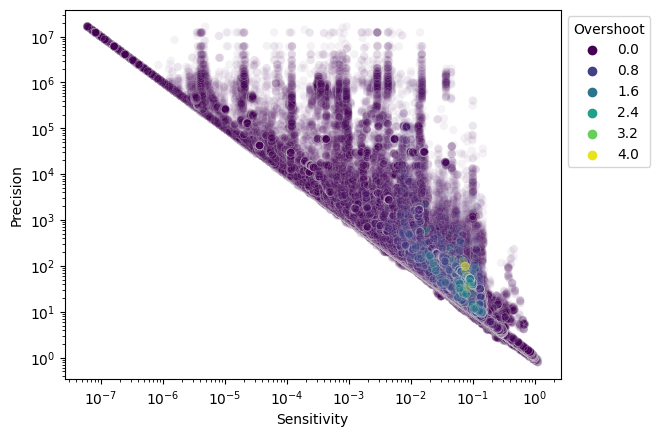

In [14]:
ax = plt.subplot(1,1,1)
sns.scatterplot(df.sort_values(by='Overshoot', ascending=True), x='Sensitivity', y='Precision', hue='Overshoot', alpha=0.05, palette='viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
plt.legend(title='Overshoot')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [15]:
df.columns

Index(['Sensitivity', 'Precision', 'Overshoot', 'Fold change',
       'Overshoot log'],
      dtype='object')

/tmp/ipykernel_1186663/1184625217.py:18: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1186663/1184625217.py:19: RuntimeWarning:

invalid value encountered in multiply



<AxesSubplot: xlabel='Weighted Log Distance', ylabel='Count'>

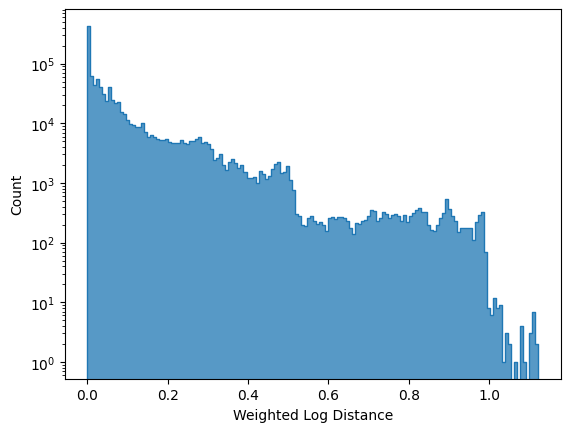

In [41]:
def mag(vec, **kwargs):
    return jnp.linalg.norm(vec, **kwargs)


def vec_distance(s, p, d):
    """ First row of each direction vector are the x's, second row are the y's """
    P = jnp.array([s, p]).T
    # P = [s.T, p.T]
    sp_rep = np.repeat(d[:, 0][:, None], repeats=len(s), axis=-1).T[:, :, None]
    AP = jnp.concatenate([sp_rep, P[:, :, None]], axis=-1)
    area = mag(jnp.cross(AP, d[None, :, :], axis=-1), axis=-1)
    D = area / mag(d)
    return D
    

def sp_prod(s, p, sp_factor=1, s_weight=0):
    """ Log product of s and p """
    s_lin = 1/p
    return s * (p * (s - s_lin)) # * sp_factor + s_weight)


def log_distance(s, p):
    lin = np.array([np.logspace(6, -3, 2), np.logspace(-6, 3, 2)])
    return vec_distance(s, p, lin)


df['Weighted Log Distance'] = np.array(log_distance(s=df['Sensitivity'].to_numpy(), p=df['Precision'].to_numpy())) # * df['Sensitivity'] 
df['SP Prod'] = sp_prod(s=df['Sensitivity'].to_numpy(), p=df['Precision'].to_numpy(), 
                                                sp_factor=1, #(d[f'Precision species-{t}'] / d[f'Sensitivity species-{t}']).max(), 
                                                s_weight=0)
df['Weighted Log Distance'] = np.where(df['Weighted Log Distance'] == np.inf, 0, df['Weighted Log Distance'])
df['Weighted Log Distance'] = np.where(df['Weighted Log Distance'] == -np.inf, 0, df['Weighted Log Distance'])

sns.histplot(df, x='Weighted Log Distance', bins=150, element='step', log_scale=[False, True])

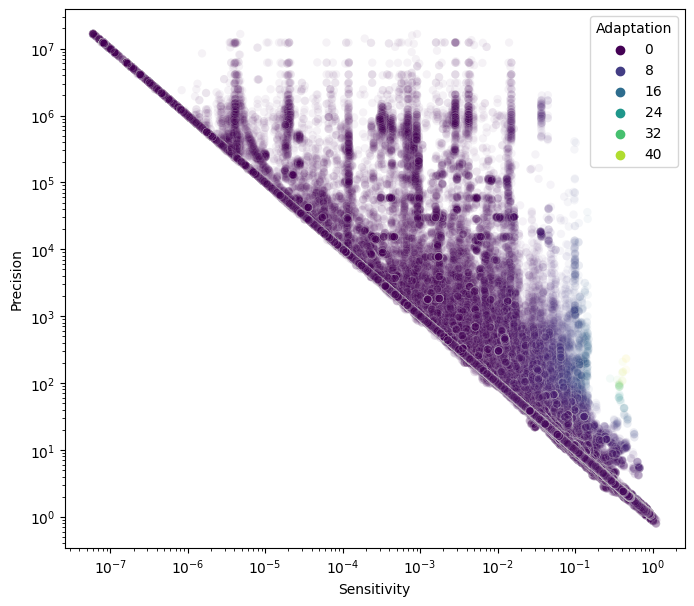

In [49]:
# df['Adaptation'] = np.log10(
#     np.power(df['Sensitivity'], -2) + 100 * np.power(df['Precision'], -2) + 0.01 * np.power(df['Fold change'], -2)
# )

df['Adaptation'] = df['Sensitivity'] * np.where(df['Precision'] > 1e2, 1e2, df['Precision']) 
df['Adaptation'] = np.where(df['Adaptation'] == np.inf, 0, df['Adaptation'])
df['Adaptation'] = np.where(df['Adaptation'] == -np.inf, 0, df['Adaptation'])

fig = plt.figure(figsize=(8, 7))
ax = plt.subplot(1,1,1)
sns.scatterplot(df, #.sort_values(by='Adaptation', ascending=True), 
                x='Sensitivity', y='Precision', alpha=0.05, 
                hue='Adaptation',
                palette='viridis')
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Sensitivity')
# plt.ylabel('Precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

fig.savefig('SP.svg')